In [4]:
import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [5]:
TRAIN_ROOT_DIR = "/kaggle/input/ixit2-slices/image slice-T2/"
TEST_ROOT_DIR  = "/kaggle/input/brats20-dataset-training-validation"

In [78]:
class BrainTumorDataset(Dataset):
    def __init__(self, train_root_dir, test_root_dir, mode="train", transform=None):
        self.train_root_dir = train_root_dir
        self.test_root_dir = test_root_dir
        self.mode = mode
        self.transform = transform
        self.image_paths = self._load_image_paths()

    def _load_image_paths(self):
        image_paths = []
        if self.mode == "train":
            for folder in os.listdir(self.train_root_dir):
                folder_path = os.path.join(self.train_root_dir, folder)
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.png'):
                        image_paths.append(os.path.join(folder_path, file_name))
        elif self.mode == "test":
            train_data_folder = os.path.join(self.test_root_dir, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
            test_data_folder  = os.path.join(self.test_root_dir, "BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData")
            for folder in os.listdir(train_data_folder):
                folder_path = os.path.join(train_data_folder, folder)
                if os.path.isfile(folder_path) and folder.endswith('.csv'):
                    continue
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.nii'):
                        image_paths.append(os.path.join(folder_path, file_name))
            for folder in os.listdir(test_data_folder):
                folder_path = os.path.join(test_data_folder, folder)
                if os.path.isfile(folder_path) and folder.endswith('.csv'):
                    continue
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.nii'):
                        image_paths.append(os.path.join(folder_path, file_name))
        return image_paths

    def _load_nii_file(self, nii_path):
        nii_data = nib.load(nii_path).get_fdata()
        slices = []
        for i in range(nii_data.shape[2]): 
            slice_data = nii_data[:, :, i]
            min_val, max_val = np.min(slice_data), np.max(slice_data)
            if max_val - min_val == 0:
                slice_data = np.zeros_like(slice_data)
            else:
                slice_data = (slice_data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
            slice_image = Image.fromarray((slice_data * 255).astype(np.uint8)).convert("L")
            slices.append(slice_image)
        return slices
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.mode == "train":
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return {"image": image, "path": img_path}
        elif self.mode == "test":
            nii_path = self.image_paths[idx]
            slices = self._load_nii_file(nii_path)
            if self.transform:
                slices = [self.transform(slice_image) for slice_image in slices]
            return {"slices": slices, "path": nii_path}

    def plot_sample(self, idx, num_slices=5):
        sample = self[idx]
        if self.mode == "train":
            image = sample["image"].permute(1, 2, 0)  # Convert CHW to HWC
            plt.figure(figsize=(10, 5))
            plt.imshow(image)
            plt.axis("off")
            plt.show()
            print(f"Train Sample - Path: {sample['path']}")
        elif self.mode == "test":
            slices = sample["slices"]
            num_slices = min(num_slices, len(slices))
            plt.figure(figsize=(15, 5))
            for i in range(num_slices):
                slice_image = slices[i].permute(1, 2, 0)[0]  # Grayscale image
                height, width = slice_image.shape
                aspect_ratio = width / height
                plt.subplot(1, num_slices, i + 1)
                plt.imshow(slice_image, cmap="gray")
                plt.title(f"Slice {i + 1}")
                plt.axis("off")
            print(f"Test Sample - Path: {sample['path']}")
            plt.show()

Train Image shape: torch.Size([3, 256, 256])
Train Image path: /kaggle/input/ixit2-slices/image slice-T2/IXI644-Guys-1121-DUAL_TSES_-s455_-0501-00005-000002-02/94.png


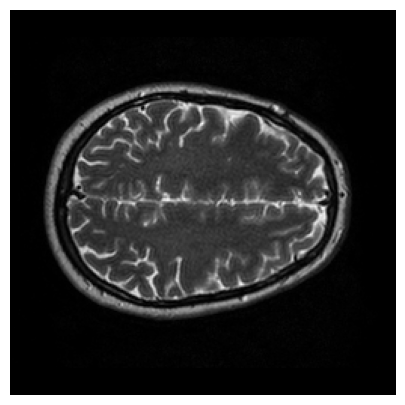

Train Sample - Path: /kaggle/input/ixit2-slices/image slice-T2/IXI644-Guys-1121-DUAL_TSES_-s455_-0501-00005-000002-02/94.png


In [81]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.ToTensor(),         # Convert to tensor
])

train_dataset = BrainTumorDataset(
    train_root_dir=TRAIN_ROOT_DIR,
    test_root_dir=TEST_ROOT_DIR,
    mode="train",
    transform=transform,
)

train_sample = train_dataset[0]
print("Train Image shape:", train_sample["image"].shape)
print("Train Image path:", train_sample["path"])

train_dataset.plot_sample(0)

Test NII Path: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_083/BraTS20_Training_083_flair.nii
Number of slices in test sample: 155
Shape of first slice: torch.Size([1, 256, 256])
Test Sample - Path: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_083/BraTS20_Training_083_flair.nii


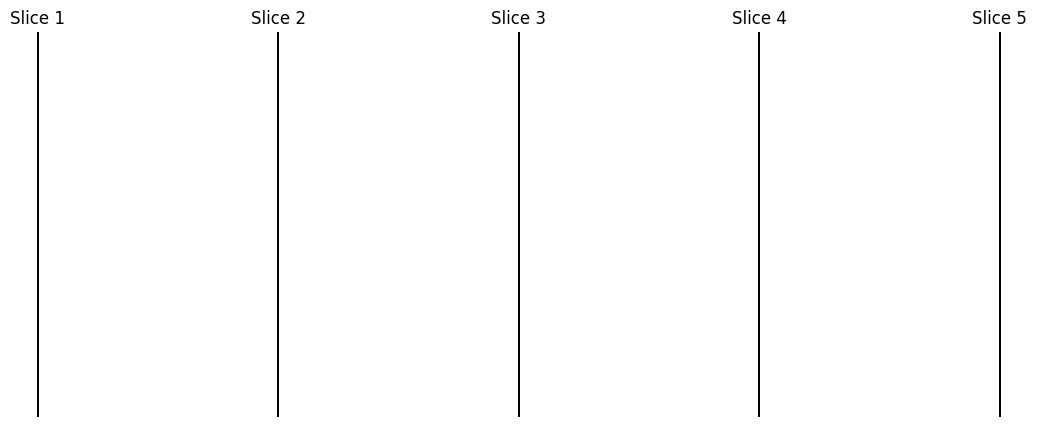

In [82]:
test_dataset = BrainTumorDataset(
    train_root_dir=TRAIN_ROOT_DIR,
    test_root_dir=TEST_ROOT_DIR,
    mode="test",
    transform=transform,
)

test_sample = test_dataset[0]
print("Test NII Path:", test_sample["path"])
print("Number of slices in test sample:", len(test_sample["slices"]))
print("Shape of first slice:", test_sample["slices"][0].shape)

test_dataset.plot_sample(0)

In [59]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class BrainTumorDataset(Dataset):
    def __init__(self, train_root_dir, test_root_dir, mode="train", transform=None):
        self.train_root_dir = train_root_dir
        self.test_root_dir = test_root_dir
        self.mode = mode
        self.transform = transform
        self.image_paths = self._load_image_paths()

    def _load_image_paths(self):
        image_paths = []
        if self.mode == "train":
            for folder in os.listdir(self.train_root_dir):
                folder_path = os.path.join(self.train_root_dir, folder)
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.png'):
                        image_paths.append(os.path.join(folder_path, file_name))
        elif self.mode == "test":
            train_data_folder = os.path.join(self.test_root_dir, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
            test_data_folder  = os.path.join(self.test_root_dir, "BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData")
            for folder in os.listdir(train_data_folder):
                folder_path = os.path.join(train_data_folder, folder)
                if os.path.isfile(folder_path) and folder.endswith('.csv'):
                    continue
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.nii'):
                        image_paths.append(os.path.join(folder_path, file_name))
            for folder in os.listdir(test_data_folder):
                folder_path = os.path.join(test_data_folder, folder)
                if os.path.isfile(folder_path) and folder.endswith('.csv'):
                    continue
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.nii'):
                        image_paths.append(os.path.join(folder_path, file_name))
        return image_paths

    def _load_nii_file(self, nii_path):
        nii_data = nib.load(nii_path).get_fdata()
        slices = []
        for i in range(nii_data.shape[2]): 
            slice_data = nii_data[:, :, i]
            min_val, max_val = np.min(slice_data), np.max(slice_data)
            if max_val - min_val == 0:
                slice_data = np.zeros_like(slice_data)
            else:
                slice_data = (slice_data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
            slice_image = Image.fromarray((slice_data * 255).astype(np.uint8)).convert("L")
            slices.append(slice_image)
        return slices
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.mode == "train":
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return {"image": image, "path": img_path}
        elif self.mode == "test":
            nii_path = self.image_paths[idx]
            slices = self._load_nii_file(nii_path)
            if self.transform:
                slices = [self.transform(slice_image) for slice_image in slices]
            return {"slices": slices, "path": nii_path}



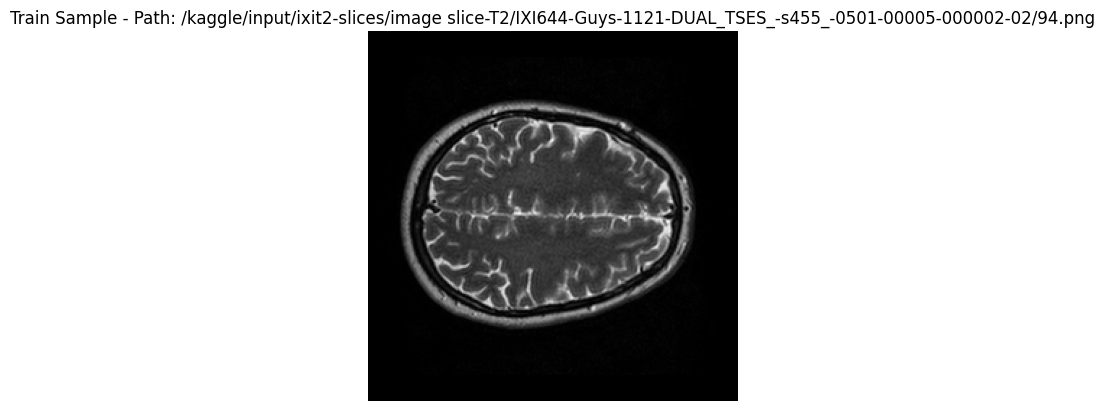

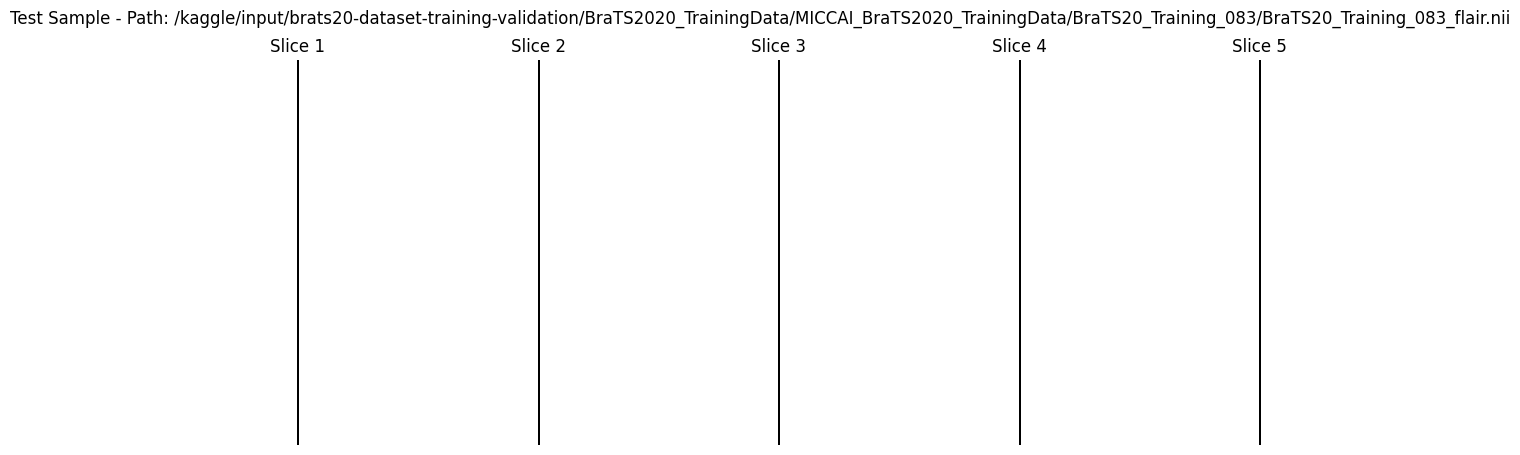

In [61]:
TRAIN_ROOT_DIR = "/kaggle/input/ixit2-slices/image slice-T2/"
TEST_ROOT_DIR  = "/kaggle/input/brats20-dataset-training-validation"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Train dataset
train_dataset = BrainTumorDataset(
    train_root_dir=TRAIN_ROOT_DIR,
    test_root_dir=TEST_ROOT_DIR,
    mode="train",
    transform=transform,
)

# Test dataset
test_dataset = BrainTumorDataset(
    train_root_dir=TRAIN_ROOT_DIR,
    test_root_dir=TEST_ROOT_DIR,
    mode="test",
    transform=transform,
)

# Plot a train sample
train_dataset.plot_sample(0)

# Plot a test sample with 5 slices
test_dataset.plot_sample(0, num_slices=5)
